# 폐업률 예측 — RandomForest + RandomizedSearchCV (멀티 CSV)

In [6]:
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             roc_auc_score, confusion_matrix, classification_report)
from scipy.stats import randint
import joblib

import matplotlib.font_manager as fm
import matplotlib

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

os.environ["PYTHONUTF8"] = "1"
os.environ["PYTHONIOENCODING"] = "utf-8"
try:
    sys.stdout.reconfigure(encoding='utf-8'); sys.stderr.reconfigure(encoding='utf-8')
except Exception: pass

%matplotlib inline


In [7]:
TRAIN_FEAT_PATH = "../datatrain_features.csv"
TRAIN_TGT_PATH  = "../datatrain_target.csv"
VAL_FEAT_PATH   = "../dataval_features.csv"
VAL_TGT_PATH    = "../dataval_target.csv"
TEST_FEAT_PATH  = "../datatest_features.csv"
TEST_TGT_PATH   = "../datatest_target.csv"
KEY_COL = ""
TARGET_DTYPE = int
MODEL_OUT = "../datarf_pipeline.joblib"


In [8]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

def read_csv_or_none(path: Path):
    return pd.read_csv(path) if path.exists() else None

def align_by_key(features_df, target_df, key_col=None, target_dtype=int):
    if features_df is None or target_df is None:
        return None, None
    if key_col and key_col in target_df.columns:
        target_cols = [c for c in target_df.columns if c != key_col]
    else:
        target_cols = target_df.columns.tolist()
    if len(target_cols) != 1:
        raise ValueError("target CSV에는 타깃 컬럼이 정확히 1개만 있어야 합니다.")
    y_col = target_cols[0]
    if key_col and (key_col in features_df.columns) and (key_col in target_df.columns):
        merged = pd.merge(features_df, target_df[[key_col, y_col]], on=key_col, how="inner")
        X = merged.drop(columns=[y_col]); y = merged[y_col].astype(target_dtype)
        return X, y
    else:
        if len(features_df) != len(target_df):
            raise ValueError("키 컬럼이 없는데 features/target 행 수가 다릅니다. KEY_COL을 지정하세요.")
        y = target_df[y_col].astype(target_dtype)
        return features_df.copy(), y

def split_num_cat(df: pd.DataFrame):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in df.columns if c not in num_cols]
    return num_cols, cat_cols

def metric_report(y_true, y_pred, y_prob=None):
    print("Accuracy :", f"{accuracy_score(y_true, y_pred):.4f}")
    print("Precision:", f"{precision_score(y_true, y_pred, zero_division=0):.4f}")
    print("Recall   :", f"{recall_score(y_true, y_pred, zero_division=0):.4f}")
    print("F1-score :", f"{f1_score(y_true, y_pred, zero_division=0):.4f}")
    if y_prob is not None:
        try:
            auc = roc_auc_score(y_true, y_prob); print("ROC-AUC  :", f"{auc:.4f}")
        except Exception: pass

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(); im = ax.imshow(cm, cmap="Blues"); ax.set_title(title)
    ax.set_xticks([0,1]); ax.set_yticks([0,1]); ax.set_xticklabels(["0","1"]); ax.set_yticklabels(["0","1"])
    for (i,j), v in np.ndenumerate(cm): ax.text(j, i, str(v), ha='center', va='center')
    plt.show()


In [9]:
train_feat = read_csv_or_none(TRAIN_FEAT_PATH)
train_tgt  = read_csv_or_none(TRAIN_TGT_PATH)
val_feat   = read_csv_or_none(VAL_FEAT_PATH)
val_tgt    = read_csv_or_none(VAL_TGT_PATH)
test_feat  = read_csv_or_none(TEST_FEAT_PATH)
test_tgt   = read_csv_or_none(TEST_TGT_PATH)

print("train_features:" train_feat.shape)
print("train_target  :" train_tgt.shape)
print("val_features  :" val_feat.shape)
print("val_target    :" val_tgt.shape)
print("test_features :" test_feat.shape)
print("test_target   :" test_tgt.shape)

display(train_feat.head() if train_feat is not None else None)
display(train_tgt.head() if train_tgt is not None else None)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (3179905375.py, line 8)

In [ ]:
X_train, y_train = align_by_key(train_feat, train_tgt, KEY_COL or None, TARGET_DTYPE)
X_val,   y_val   = align_by_key(val_feat,   val_tgt,   KEY_COL or None, TARGET_DTYPE)
X_test,  y_test  = align_by_key(test_feat,  test_tgt,  KEY_COL or None, TARGET_DTYPE)

print("X_train:", None if X_train is None else X_train.shape)
print("y_train:", None if y_train is None else y_train.shape)
print("X_val  :", None if X_val   is None else X_val.shape)
print("y_val  :", None if y_val   is None else y_val.shape)
print("X_test :", None if X_test  is None else X_test.shape)
print("y_test :", None if y_test  is None else y_test.shape)


X_train: (25812, 66)
y_train: (25812,)
X_val  : (3687, 66)
y_val  : (3687,)
X_test : (7376, 66)
y_test : (7376,)


Numeric cols: 66 Categorical cols: 0

=== Validation (Baseline) ===
Accuracy : 0.7266
Precision: 0.7944
Recall   : 0.6630
F1-score : 0.7228
ROC-AUC  : 0.8128


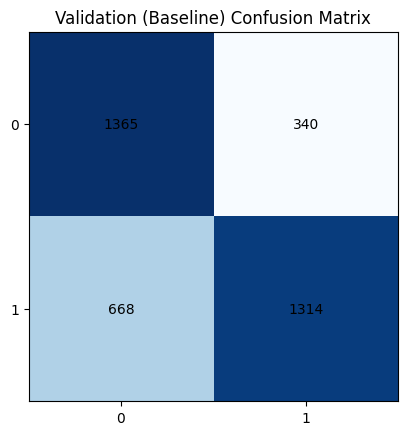

In [ ]:
assert X_train is not None, "train 데이터를 먼저 준비하세요."

num_cols, cat_cols = split_num_cat(X_train)
print("Numeric cols:", len(num_cols), "Categorical cols:", len(cat_cols))

preproc = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
)

rf = RandomForestClassifier(n_estimators=200, max_features="sqrt", random_state=42, n_jobs=-1)
pipe = Pipeline(steps=[("prep", preproc), ("clf", rf)])

pipe.fit(X_train, y_train)

def evaluate(name, X, y):
    print(f"\n=== {name} ===")
    y_pred = pipe.predict(X)
    y_prob = None
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        try: y_prob = pipe.predict_proba(X)[:,1]
        except Exception: y_prob = None
    metric_report(y, y_pred, y_prob)
    plot_confusion_matrix(y, y_pred, f"{name} Confusion Matrix")

if X_val is not None and y_val is not None:
    evaluate("Validation (Baseline)", X_val, y_val)
else:
    evaluate("Train (Baseline)", X_train, y_train)


In [ ]:
param_distributions = {
    'clf__n_estimators': randint(120, 320),
    'clf__max_depth': [None, 10, 14, 18],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__min_samples_split': randint(2, 11),
    'clf__min_samples_leaf': randint(1, 5),
}

rnd = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    n_jobs=1,
    verbose=0,
    random_state=42,
)


In [ ]:
rnd.fit(X_train, y_train)
print("최적 파라미터:", rnd.best_params_)
print("최적 점수   :", f"{rnd.best_score_:.4f}")
pipe = rnd.best_estimator_


최적 파라미터: {'clf__max_depth': 10, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 10, 'clf__n_estimators': 209}
최적 점수   : 0.7198



=== Validation (Tuned) ===
Accuracy : 0.7242
Precision: 0.8056
Recall   : 0.6418
F1-score : 0.7144
ROC-AUC  : 0.8168


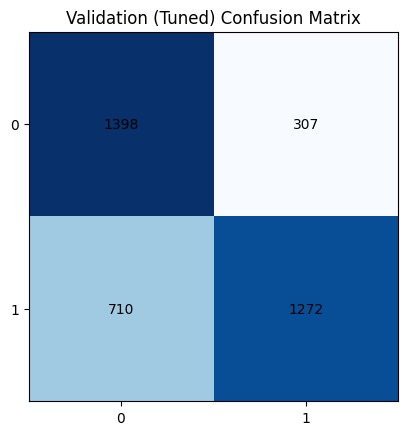


=== Test (Tuned) ===
Accuracy : 0.7019
Precision: 0.7830
Recall   : 0.5846
F1-score : 0.6694
ROC-AUC  : 0.7950


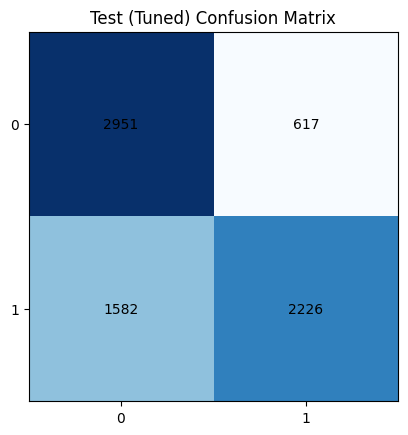

In [ ]:
if X_val is not None and y_val is not None:
    evaluate("Validation (Tuned)", X_val, y_val)
if X_test is not None and y_test is not None:
    evaluate("Test (Tuned)", X_test, y_test)


,feature,importance
0,야간_매출_비율,0.095792
1,시간대_21_24_매출_금액_lag1,0.064201
2,시간대_21_24_매출_금액_lag2,0.055978
3,개업_률_lag1,0.054663
4,경쟁_밀도,0.042449
5,프랜차이즈_비율,0.037167
6,프랜차이즈_점포_수_lag1,0.034856
7,주말_매출_비율,0.031894
8,건당_매출,0.028152
9,개업_률_lag2,0.027059


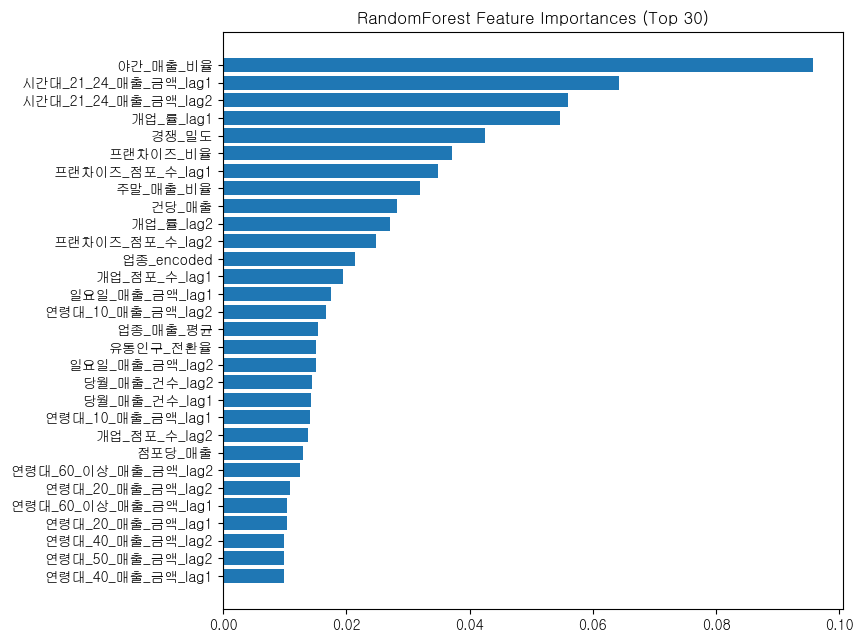

In [ ]:
clf = pipe.named_steps["clf"]
ohe = pipe.named_steps["prep"].named_transformers_["cat"]

num_names = num_cols
try: cat_names = ohe.get_feature_names_out(cat_cols).tolist()
except Exception: cat_names = []

feature_names = num_names + cat_names
importances = clf.feature_importances_
order = np.argsort(importances)[::-1]

topk = min(30, len(importances))
top_features = [(feature_names[i] if i < len(feature_names) else f"f{i}", importances[i]) for i in order[:topk]]
imp_df = pd.DataFrame(top_features, columns=["feature", "importance"])
display(imp_df)

plt.figure(figsize=(8, max(4, topk*0.25)))
plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
plt.title("RandomForest Feature Importances (Top 30)")
plt.show()


In [ ]:
joblib.dump(pipe, MODEL_OUT)
MODEL_OUT, Path(MODEL_OUT).exists()

(WindowsPath('../data/rf_pipeline.joblib'), True)